In [1]:
import pandas, scipy, numpy
import sklearn.ensemble
import sklearn.metrics
from IPython.display import Image

import sys
sys.path.append('./github/local-adverse-detection/')
from lad import lad

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Load data

In [2]:
# German credit score

#1 (bad loans) and 2 (good loans)
path_dataset='/Users/axa/Data/data-german-credit.csv'
X = pandas.read_csv(path_dataset, delimiter=",", index_col=0)
y = X.label
X = X.iloc[:,X.columns != 'label']
X = (X-X.mean())/X.std()

#### Blackbox training

In [3]:
## Train a back-box classifier on the synthetic dataset
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20)

clf = sklearn.ensemble.RandomForestClassifier(n_estimators=200)
clf.fit(train, labels_train)

print(sklearn.metrics.accuracy_score(labels_test, clf.predict(test)))
print(sklearn.metrics.classification_report(labels_test, clf.predict(test)))

0.745
             precision    recall  f1-score   support

          1       0.79      0.88      0.84       147
          2       0.53      0.36      0.43        53

avg / total       0.72      0.74      0.73       200



#### Local Surrogate

In [4]:
ls = lad.LocalSurrogate(X, blackbox=clf, n_support_points=100, max_depth=3)

In [5]:
# Test on a sample

x_toexplain = X.iloc[13].copy()
#x_toexplain.iloc[1] = x_toexplain.iloc[1]+0.01
support_points, surrogate = ls.get_local_surrogate(x_toexplain)

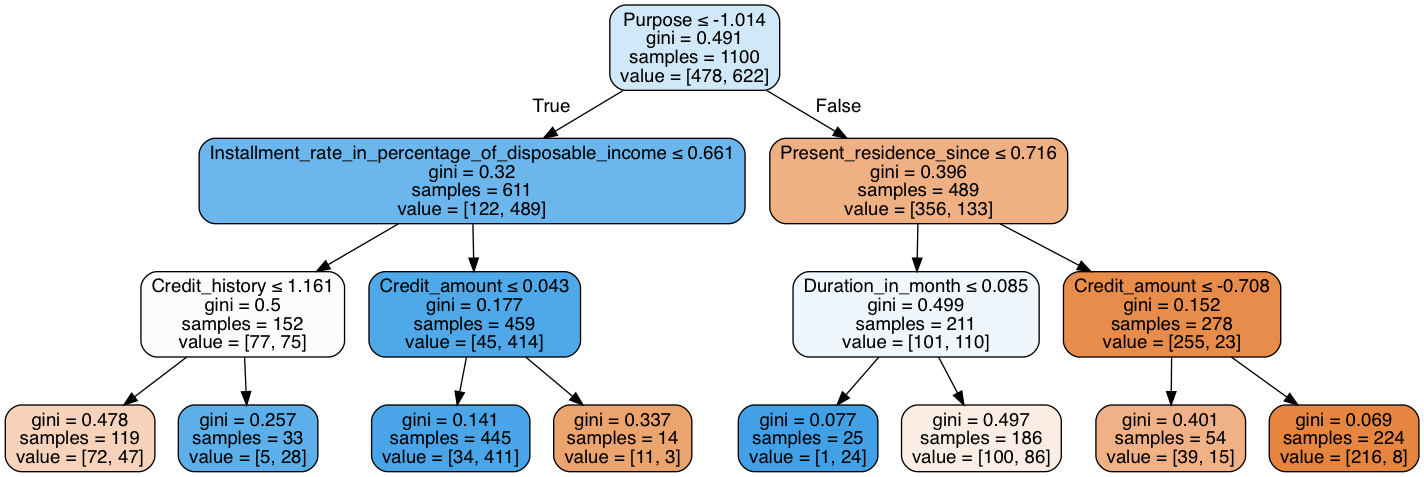

In [6]:
Image(ls.plot_decision_tree(X, surrogate))

#### Assess local surrogate fidelity

In [7]:
from scipy.spatial.distance import euclidean
from sklearn.metrics import euclidean_distances

def get_random_points_hypersphere(x_center, radius_, n_points_):

        res = []
        while len(res) < n_points_:
        
            n_points_left_ = n_points_ - len(res)
            # About half the points are lost in the test hypercube => hypersphere
            lbound = numpy.repeat([x_center.values-(radius_/2.)], n_points_left_*2, axis=0)
            hbound = numpy.repeat([x_center.values+(radius_/2.)], n_points_left_*2, axis=0)
            points = numpy.random.uniform(low=lbound, high=hbound)
            # Check if x_generated is within hypersphere (if kind=='hypersphere')
            for x_generated in points:
                if euclidean(x_generated, x_center.values) < radius_:
                    res.append(x_generated)
                if len(res) == n_points_:
                    break

        return pandas.DataFrame(numpy.array(res))
    
def surrogate_fidelity(Xtest, blackbox, surrogate, metric):
    
    ypred_blackbox = blackbox.predict(Xtest)
    ypred_surrogate = surrogate.predict(Xtest)
    return metric(ypred_surrogate, ypred_blackbox)

def growing_surrogate_fidelity(x_toexplain, X, blackbox, surrogate, metric, n_points_=100,
                              radius_perc=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]):
    
    dists = euclidean_distances(x_toexplain.to_frame().T, X)
    dists = pandas.Series(dists[0], index=X.index)
    radius_all_ = dists.max()*numpy.array(radius_perc)
    
    res = {}
    for i in range(len(radius_all_)):
        Xtest = get_random_points_hypersphere(x_toexplain, radius_all_[i], n_points_)
        res[radius_perc[i]] = surrogate_fidelity(Xtest, clf, surrogate, accuracy_score)
        
    return pandas.Series(res)

In [39]:
from sklearn.metrics import accuracy_score

n_points_ = 1000
xs_toexplain = numpy.random.choice(X.index, 100)

res_ = {}
for i in range(len(xs_toexplain)):
    print(i)
    x_toexplain = X.iloc[xs_toexplain[i]]
    ls = lad.LocalSurrogate(X, blackbox=clf, n_support_points=100, max_depth=3)
    support_points, surrogate = ls.get_local_surrogate(x_toexplain)
    res_[i] = growing_surrogate_fidelity(x_toexplain, X, clf, surrogate, accuracy_score, n_points_=n_points_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [40]:
res_ = pandas.DataFrame(res_)

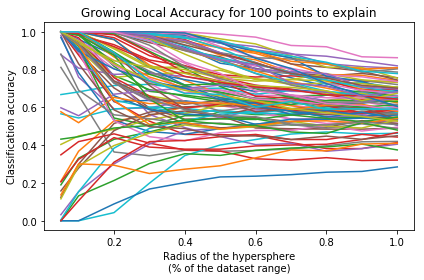

In [41]:
for j in res_.columns:
    plot(res_.iloc[:,j])
title('Growing Local Accuracy for '+str(len(xs_toexplain))+' points to explain')
xlabel('Radius of the hypersphere\n(% of the dataset range)')
ylabel('Classification accuracy')
tight_layout()
savefig('/Users/axa/Desktop/ECML_adversarial/local_fidelity.png')
savefig('/Users/axa/Desktop/ECML_adversarial/local_fidelity.pdf')

In [42]:
df = res_.copy()

In [43]:
dic = {}
c = 0
for j in range(df.shape[1]):
    for i in range(df.shape[0]):
        dic[c] = pandas.Series([df.iloc[i,j], df.index[i]], index=['accuracy','perc'])
        c += 1

In [44]:
dic = pandas.DataFrame(dic).T

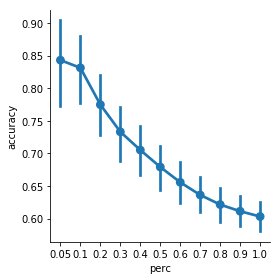

In [45]:
import seaborn as sns
g = sns.factorplot(x="perc", y="accuracy", data=dic)

savefig('/Users/axa/Desktop/ECML_adversarial/local_fidelity_agg.png')
savefig('/Users/axa/Desktop/ECML_adversarial/local_fidelity_agg.pdf')

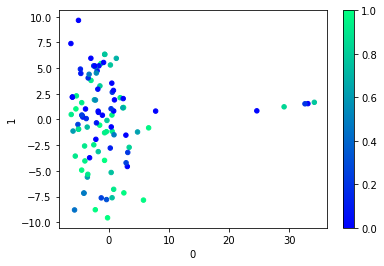

In [27]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso = iso.fit(X)

X_embedded = iso.transform(X.iloc[xs_toexplain])

df_ = res_.copy()
df_.columns = X.iloc[xs_toexplain].index

f, ax = subplots(1)
df = pandas.DataFrame(X_embedded)

df.plot(kind='scatter', x=0, y=1, c=df_.loc[0.1], ax=ax, colormap='winter')

#### Give some insights with provided explanation for potential adverse

#### Check explanations (ie. given an adverse generated from a true point, fit the local surrogate to oberse features)